# Week 1

In [115]:
import numpy as np
from astropy.io import fits
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Astronomy/Codes/Data_Driven_Astronomy_Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The pulsars have a very feeble signal to noise ratio, hence they are buried in the noise and hence hard to detect. It is also possible that they might be visible in one of the captures but not in the other. A mean stack adds up all the values for each pixel in all the images hence increasing the signal to noise ratio.

- This is because the noise is mean randomly distributed, that its mean would turn out to be zero. Hence the noise cancels out leaving out the signal from the pulsar. 

- But is some cases when the data is skewed, it is better to use the Median as it is a better indicator of the data as compared to the mean. This is becase the median is not affected by the presence of outliers, whereas the mean gets deflected when there is a substantial presence of out

## Mean Stack

The value of central pixel is:  0.01517697935923934


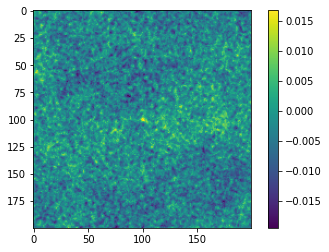

In [116]:
def mean_fits(files):
  data_all = []
  for i in files:
    hdulist = fits.open(path+'Week1/'+i)
    data_all.append(hdulist[0].data)
  sh = data_all[0].shape
  s = np.zeros(sh)
  for i in data_all:
    s+=i
  s = s/len(data_all)
  return s
  
# Test your function with examples from the question
data  = mean_fits(['image0.fits', 'image1.fits', 'image2.fits','image3.fits'])
print("The value of central pixel is: ",data[100, 100])

# You can also plot the result:
import matplotlib.pyplot as plt
plt.imshow(data.T, cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

## Median Stack

0.010775766335427761 0.017031484000654018 104
0.011797304265201092 0.06109176500012836 200
The mean Image stack


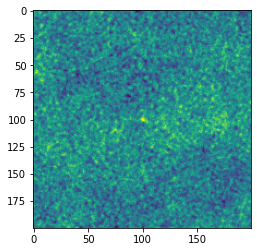

The median Image stack


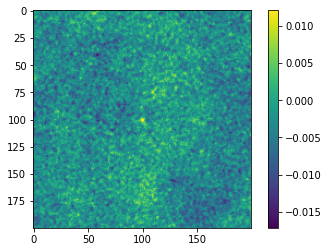

In [117]:
import numpy as np
import statistics
from astropy.io import fits
import time
import sys


def median_fits(files):
    data_all = []
    fitsall = []
    start = time.perf_counter()
    for i in files:
        hdulist = fits.open(path+ 'Week1/' + i)
        fitsall.append(hdulist)
        data_all.append(hdulist[0].data)
    shape = data_all[0].shape
    stack = np.vstack([im.flatten() for im in data_all])
    median = np.median(stack, axis=0).reshape(shape)
    end = time.perf_counter() - start
    memory = sys.getsizeof(fitsall)
    return (median, end, memory)


# Run your function with first example in the question.
result = median_fits(['image0.fits', 'image1.fits'])
print(result[0][100, 100], result[1], result[2])

# Run your function with second example in the question.
result1 = median_fits(['image{}.fits'.format(str(i)) for i in range(11)])
print(result1[0][100, 100], result1[1], result1[2])

# You can also plot the result:
import matplotlib.pyplot as plt

print('The mean Image stack')
plt.imshow(data.T, cmap=plt.cm.viridis)
plt.show()
print('The median Image stack')
plt.imshow(result1[0], cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

## Bin Approximation Method for Median Calculation

Calculation of the median requires all the data to be in the memory at once, this becomes an issue when we have a large dataset, with hundereds of FITS files. Hence we have a method called the `running median` which saves space by loading only 1 image at a time. 

### Bin Approx Algorithm

The idea is to find the median from the data's histogram The full algorithm for N datapoints works as:

- Calculate their mean and standard deviation, $\mu$ and $\sigma$.
- Set the bounds: `minval`$=\mu-\sigma$ and `maxval`$=\mu+\sigma$. Any `value`$\geq$ `maxval` is ignored.
- Set the bin width: `width` = $\frac{2\sigma}{B}$. Where $B$ is the total number of bins to be made. 
- Make an ignore bin for counting `value`$<$`minval`.
- Make $B$ bins for counting values in `minval` and `maxval`. Eg the first bin is `minval`$\leq$`value`$<$`minval`+`width`.
- Count the number of values that fall into each bin. 
- Sum these counts until `total`$\geq(N+1)/2$. Remember to start from the ignore bin. 
- Return the midpoint of the bin that exceeded (N+1)/2.

In [118]:
import numpy as np


def median_bins(arr, b):
    m, s = np.mean(arr), np.std(arr)
    minval, maxval = m - s, m + s
    arr = [i for i in arr if i < maxval]
    w = 2 * s / b
    bins = np.arange(minval, maxval + w, w)
    c = len([i for i in arr if i < minval])
    final = np.histogram(arr, bins)

    return (m, s, c, np.array(final[0]))


def median_approx(arr, b):
    m, s = np.mean(arr), np.std(arr)
    minval, maxval = m - s, m + s
    length = (len(arr) + 1) / 2
    arr = [i for i in arr if i < maxval]
    w = 2 * s / b
    bins = np.arange(minval, maxval + w, w)
    c = len([i for i in arr if i < minval])
    final = np.histogram(arr, bins)
    counts = final[0]
    sum_bins = [c]
    s = c
    for i in counts:
        s += i
        sum_bins.append(s)
    for i in range(len(sum_bins)):
        if sum_bins[i] >= length:
            c = i
            break
        else:
            c = len(sum_bins) - 1
    median = (bins[c - 1] + bins[c]) / 2
    return median


print(median_bins([1, 1, 3, 2, 2, 6], 3))
print("Median: ", median_approx([1, 1, 3, 2, 2, 6], 3), "\n")
print(median_bins([1, 5, 7, 7, 3, 6, 1, 1], 4))
print("Median: ", median_approx([1, 5, 7, 7, 3, 6, 1, 1], 4), "\n")
print(median_bins([0, 1], 5))
print("Median: ", median_approx([0, 1], 5), "\n")

(2.5, 1.707825127659933, 0, array([2, 3, 0]))
Median:  2.5 

(3.875, 2.521780125229002, 3, array([0, 1, 1, 1]))
Median:  4.50544503130725 

(0.5, 0.5, 0, array([1, 0, 0, 0, 0]))
Median:  0.9 



## Bin Approximation of FITS Files

In [119]:
# Import the running_stats function

import numpy as np
from astropy.io import fits

# Write your median_bins_fits and median_approx_fits here:
def median_bins_fits(filenames,B):
  mean, std = running_stats(filenames)
  smaller = np.zeros(mean.shape) #200x200
  bins = np.zeros((mean.shape[0],mean.shape[1],B))
  minval = mean-std
  bin_width = (2*std)/B
  
  for i in filenames:
    hdulist = fits.open(path+'Week2/'+i)
    image = hdulist[0].data
    
    for x in range(mean.shape[0]):
      for y in range(mean.shape[1]):
        binmax = minval[x][y]
        pixel = image[x][y]
        
        if pixel<minval[x][y]:
          smaller[x][y]+=1
        else:
          for j in range(B):
            binmax+=bin_width[x][y]
            if pixel<binmax:
              bins[x][y][j]+=1
              break
  return (mean, std, smaller, bins)  

def median_approx_fits(filenames,B):
  
  mean, std, total, bins = median_bins_fits(filenames,B)
  
  minval = mean - std
  bin_width = (2*std)/B
  target = (len(filenames)+1)/2
  answer = np.zeros(mean.shape)
  for x in range(answer.shape[0]):
    for y in range(answer.shape[1]):
      for i in range(B):
        total[x][y]+=bins[x][y][i]
        if total[x][y]>= target:
          answer[x,y] = (i*bin_width[x,y]) + minval[x,y] + bin_width[x,y]/2
          break
  return answer


# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.

  # Run your function with examples from the question.
mean, std, left_bin, bins = median_bins_fits(['image0.fits', 'image1.fits', 'image2.fits'], 5)
median = median_approx_fits(['image0.fits', 'image1.fits', 'image2.fits'], 5)

## Further Reading

**1. Pulsars**

- Introduction to Pulsars (from CSIRO, beginner) Hobbs, M. (n.d.). An introduction to pulsars. Retrieved February 14, 2017, from http://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html 

- Pulsar Properties (from NRAO, advanced) National Radio Astronomy Observatory. (2010).  Pulsar Properties. Retrieved February 14, 2017, from http://www.cv.nrao.edu/course/astr534/Pulsars.html

**2. Statistics**
- Additional material located here: Department of Physics and Astronomy, University of British Columbia. (n.d.). Practical Statistics for Astronomers. Retrieved from http://www.astro.ubc.ca/people/jvw/ASTROSTATS/ 



# Week 2

## **Cross Matching**

When investigating astronomical objects, like **active galactic nuclei (AGN)**, astronomers compare data about those objects from different telescopes at different wavelengths.

This requires positional cross-matching to find the closest counterpart within a given radius on the sky.

In this activity you'll cross-match two catalogues: one from a radio survey, the [AT20G Bright Source Sample (BSS) catalogue](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) and one from an optical survey, the [SuperCOSMOS all-sky galaxy catalogue](http://ssa.roe.ac.uk/allSky).

The BSS catalogue lists the brightest sources from the AT20G radio survey while the SuperCOSMOS catalogue lists galaxies observed by visible light surveys. If we can find an optical match for our radio source, we are one step closer to working out what kind of object it is, e.g. a galaxy in the local Universe or a distant quasar.

We've chosen one small catalogue (BSS has only 320 objects) and one large one (SuperCOSMOS has about 240 million) to demonstrate the issues you can encounter when implementing cross-matching algorithms.


The positions of stars, galaxies and other astronomical objects are usually recorded in either [equatorial](https://astronomy.swin.edu.au/cosmos/E/Equatorial+Coordinate+System) or [Galactic coordinates](https://astronomy.swin.edu.au/cosmos/N/North+Galactic+Pole).

Equatorial coordinates are fixed relative to the celestial sphere, so the positions are independent of when or where the observations took place. They are defined relative to the celestial equator (which is in the same plane as the Earth's equator) and the ecliptic (the path the sun traces throughout the year).

A point on the celestial sphere is given by two coordinates:

- Right ascension: the angle from the vernal equinox to the point, going east along the celestial equator;
- Declination: the angle from the celestial equator to the point, going north (negative values indicate going south).
The vernal equinox is the intersection of the celestial equator and the ecliptic where the ecliptic rises above the celestial equator going further east.

The coordinates of stars in the sky will change slightly over the years due to the slow wobble of Earth's axis. Therefore, it is important to specify the epoch or time period which we are using as a reference for the celestial coordinate system.